## Hands on Implementation

In [7]:
import time
from IPython.display import clear_output
import numpy as np
import matplotlib as mpl

# import sympy
from sympy import symbols, pprint
from sympy import sin, cos, asin, acos, atan, pi, sqrt
from sympy import Matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sympy import lambdify
# import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

from IPython import display # for the animation
# import matplotlib as mpl
# mpl.use('Qt5Agg')
# plt.ion()

import matplotlib.pyplot as plt
# plt.ion()

# for the symbolic manipulation of jacobian
import sympy as sp
# from sympy import symbols
#from sympy import sin, cos, asin, acos, pi, atan2, sqrt
from sympy.utilities.lambdify import lambdify
#from sympy import Matrix

from scipy.optimize import minimize
from scipy.optimize import fsolve

import time

import odrive
from odrive.utils import *
import odrive.enums
%matplotlib inline

## Connect to ODrive

In [88]:
odrv0 = odrive.find_any()
if odrv0 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv0.serial_number))
    
    m0 = odrv0.axis0.motor.is_calibrated
    m1 = odrv0.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')
    

Connected!
Odrive serial 53194131976757
Motor 0 calibrated: False
Motor 1 calibrated: False


In [72]:
m0 = odrv0.axis0.motor.is_calibrated
m1 = odrv0.axis1.motor.is_calibrated
    
print('Motor 0 calibrated: {}'.format(m0))
print('Motor 1 calibrated: {}'.format(m1))

Motor 0 calibrated: False
Motor 1 calibrated: False


In [51]:
# Setting the velocity and calibration current limit
odrv0.axis0.controller.config.vel_limit=200000
odrv0.axis1.controller.config.vel_limit=200000
odrv0.axis0.motor.config.calibration_current=20.0
odrv0.axis1.motor.config.calibration_current=20.0


NameError: name 'odrv0' is not defined

#### Calibrating the Motors

In [105]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

time.sleep(15)

print('\t Motor 0 calibration result: {} \r\n'.format(odrv0.axis0.motor.is_calibrated), 
      '\t Motor 1 calibration result: {}'.format(odrv0.axis1.motor.is_calibrated))


	 Motor 0 calibration result: True 
 	 Motor 1 calibration result: True


In [4]:
# Function to make the motors return to idle mode 
def motor_idle(): 
    odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

#### Defining variables for Forward Kinematic equation

In [8]:

(theta_l, 
 theta_r,
 l1, 
 l2,
 w) = symbols(""" theta_l
                         theta_r
                         l1 
                         l2
                         w """ , real = True)

#### Forward Kinematics definition

In [9]:
A = 2*l2*l1*sin(theta_l)- 2*l1*l2*sin(theta_r)
B = 2*l2*w - 2*l1*l2*cos(theta_r) + 2*l2*l1*cos(theta_l)
C = 2*(l1**2) + w**2 - 2*l1*l1*sin(theta_l)*sin(theta_r) - 2*l1*w*cos(theta_r) + 2*l1*w*cos(theta_l) - 2*l1*l1*cos(theta_l)*cos(theta_r)

theta3_1 = 2*atan((A + sqrt(A**2 + B**2 - C**2))/(B-C))
theta3_2 = 2*atan((A - sqrt(A**2 + B**2 - C**2))/(B-C))

xc_1 = l1*cos(theta_l) + l2*cos(theta3_1) + w/2
xc_1
xc_2 = l1*cos(theta_l) + l2*cos(theta3_2) + w/2
xc_2

yc_1 = l1*sin(theta_l) + l2*sin(theta3_1)
yc_1
yc_2 = l1*sin(theta_l) + l2*sin(theta3_2)
yc_2
#sympy.simplify(theta3_1)
#sympy.simplify(theta3_2)

l1*cos(theta_l) + l2*cos(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) + sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2))) + w/2

l1*cos(theta_l) + l2*cos(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) - sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2))) + w/2

l1*sin(theta_l) + l2*sin(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) + sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2)))

l1*sin(theta_l) + l2*sin(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) - sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2)))

In [10]:
FK1 = Matrix([[xc_1],
             [yc_1]])
FK2 = Matrix([[xc_2],
             [yc_2]])

In [11]:
FK1_fast = lambdify((theta_l,theta_r,l1,l2,w),FK1)
FK2_fast = lambdify((theta_l,theta_r,l1,l2,w),FK2)

#### Code to record $\theta_R$ and $\theta_L$ to plot ($\theta_R,\theta_L$) workspace

In [13]:
theta=[]
while True:
    theta_R=(np.around(odrv0.axis0.encoder.pos_estimate)-(18793/7))*(-35/788)
    theta_L=(np.around(odrv0.axis1.encoder.pos_estimate)-817)/(-23.5)
    theta.append([theta_R,theta_L])
    
Angle_value = np.asarray(theta)
np.save('Angle_Workspace',Angle_value)

NameError: name 'odrv0' is not defined

#### Plotting the angle work space

In [14]:
theta=np.load('Angle_Workspace.npy')

Text(0.5, 0, '$\\theta_R$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, 'Angle workspace plot')

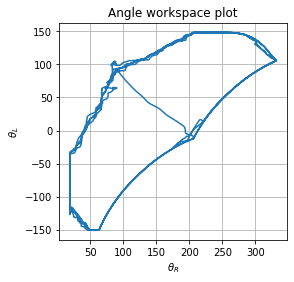

In [18]:

plt.plot(*zip(*theta))
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_L$')
plt.title('Angle workspace plot')
plt.gca().set_aspect('equal')
plt.grid()

#### Plotting original x-y workspace from original angle workspace

In [19]:
data_pointsFK1 = np.zeros([1,2])
data_pointsFK2 = np.zeros([1,2])
for k in range(0,len(theta)):
    
    data_pointsFK1 = np.append(data_pointsFK1,FK1_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
    data_pointsFK2 = np.append(data_pointsFK2,FK2_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0
                               
data_pointsFK1 = data_pointsFK1[1:data_pointsFK1.shape[0],:]
data_pointsFK2 = data_pointsFK2[1:data_pointsFK2.shape[0],:]

Text(0.5, 0, '$X$')

Text(0, 0.5, '$Y$')

Text(0.5, 1.0, '(X,Y) workspace plot')

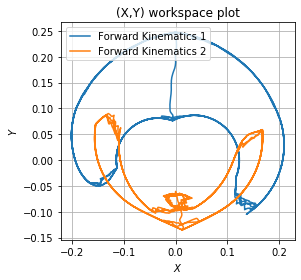

In [20]:
# plt.scatter(*zip(*data_points1))\
%matplotlib inline
plt.clf()
plt.plot(data_pointsFK1[:,0],data_pointsFK1[:,1])
plt.plot(data_pointsFK2[:,0],data_pointsFK2[:,1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('(X,Y) workspace plot')
plt.grid()
plt.gca().set_aspect('equal')
plt.legend(['Forward Kinematics 1','Forward Kinematics 2'])
# plt.scatter(*zip(*data_points2))

As seen from the above diagram, Forward kinematics 2 gives us values mostly in the negative Y direction. These are physically unreachable points in the workspace. Thus Forward Kinematics 1 is the correct mapping from the angle workspace to the cartesian workspace. 

#### Code to record toe Coordinates (x,y) from FK Eqs and store them to plot the cartesian workspace

In [18]:
angle=0
theta=[]
while True:
    theta_R=(np.around(odrv0.axis0.encoder.pos_estimate)-(18793/7))*(-35/788)
    theta_L=(np.around(odrv0.axis1.encoder.pos_estimate)-817)/(-23.5)
    print("thetaR: ",np.around(theta_R), "thetaL: ",np.around(theta_L) )
    data_points1= FK1_fast(np.radians(theta_L),np.radians(theta_R),0.09,0.16,0.07) 
    data_points2= FK2_fast(np.radians(theta_L),np.radians(theta_R),0.09,0.16,0.07)
    print('FK1: ',data_points1.T ,'FK2:', data_points2.T)
    
#     theta.append([theta_R,theta_L])   
    time.sleep(0.5)
    clear_output()

NameError: name 'odrv0' is not defined

#### Code to Record angle values for Cyclic trajectory 

In [298]:
motor_idle()

In [290]:
# plt.axis([-10, 330, -140, 140])
cyclic_theta_val=[]
duration=1
timeout = time.time() + 60*(1/2)   # 5 minutes from now
while True:
#     test = 0
    if time.time() > timeout:
        break
    
#     y = np.random.random()
#     theta_R=(np.around(odrv0.axis0.encoder.pos_estimate)-(18793/7))*(-35/788)
#     theta_L=(np.around(odrv0.axis1.encoder.pos_estimate)-817)/(-23.5)
    R=odrv0.axis0.encoder.pos_estimate
    L=odrv0.axis1.encoder.pos_estimate
    cyclic_theta_val.append([R,L])
#     tes/t = test - 1
#     plt.scatter(*zip(*cyclic_theta_val) )
    time.sleep(0.01)
motor_idle()
# plt.show()

#### Code to physically implement Cyclic Trajectory

In [19]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
for i in range(0,len(cyclic_theta_val)):
#     pos_R=cyclic_theta_val[i][0]*(-788/35)+(18793/7)
#     pos_L=(cyclic_theta_val[i][1]*23.5)+817
    odrv0.axis0.controller.set_pos_setpoint(cyclic_theta_val[i][0],0,0)
    odrv0.axis1.controller.set_pos_setpoint(cyclic_theta_val[i][1],0,0)
    time.sleep(0.001)

NameError: name 'odrv0' is not defined

The Cyclic trajectory video can be found on the following link: [YouTube](https://www.youtube.com/watch?v=HKVOM5uDiIY&feature=youtu.be)